In [1]:
import numpy as np

import skimage.io as skio
import skimage.util as sku
import skimage.segmentation as seg
from skimage.future import graph
import skimage.filters as skf
import skimage.color as skc

from sklearn.neighbors import LocalOutlierFactor as LOF
from sklearn.metrics import adjusted_rand_score

import networkx as nx
import dynSIS
import importlib
importlib.reload(dynSIS)

<module 'dynSIS' from '/mounts/u-amo-d0/ugrad/connor/docs/homework/cs687/project/src/notebooks/dynSIS.py'>

In [2]:
def hufbauer_alpha(image, labels, connectivity=2, fudge=1e-8):
    rag = graph.RAG(labels, connectivity=connectivity)

    for n in rag:
        rag.node[n].update({'labels': [n],
                            'pixel count': 0,
                            'total color': np.array([0, 0, 0],
                                                    dtype=np.double)})

    for index in np.ndindex(labels.shape):
        current = labels[index]
        rag.node[current]['pixel count'] += 1
        rag.node[current]['total color'] += image[index]

    for n in rag:
        rag.node[n]['mean color'] = (rag.node[n]['total color'] /
                                     rag.node[n]['pixel count'])
        rag.node[n]['alpha'] = np.sum(rag.node[n]['mean color'] ** 2)

    for x, y, d in rag.edges(data=True):
        # TODO: might be wrong, check later
        #d['weight'] = 1 / (fudge + (rag.node[x]['alpha'] - rag.node[y]['alpha']) ** 2)
        d['weight'] = -((rag.node[x]['alpha'] - rag.node[y]['alpha']) ** 2.)
        #d['weight'] = np.log((rag.node[x]['alpha'] - rag.node[y]['alpha']) ** 2.)

    return rag

In [3]:
def hufbauer_beta(image, labels, connectivity=2):
    image = skc.rgb2lab(image)[:, :, [1,2]]
    rag = graph.RAG(labels, connectivity=connectivity)

    for n in rag:
        rag.node[n].update({'labels': [n],
                            'pixel count': 0,
                            'total hue': np.array([0, 0],
                                                    dtype=np.double)})

    for index in np.ndindex(labels.shape):
        current = labels[index]
        rag.node[current]['pixel count'] += 1
        rag.node[current]['total hue'] += image[index]

    for n in rag:
        rag.node[n]['mean hue'] = (rag.node[n]['total hue'] /
                                     rag.node[n]['pixel count'])

    for x, y, d in rag.edges(data=True):
        # TODO: might be wrong, check later
        diff = 1 / (1 + (rag.node[x]['mean hue'] - rag.node[y]['mean hue']) ** 2)
        diff = np.linalg.norm(diff)
        d['weight'] = diff

    return rag

In [4]:
def normalize_graph(g):
    values = []
    for _, _, d in g.edges(data=True):
        values.append(d["weight"])
    values = np.sort(values)
    
    # outlier smoothing
    outliers = LOF().fit_predict(values[:, None])
    values =  values[outliers > 0]
    min_val, max_val = values.min(), values.max() - values.min()
    
    for _, _, d in g.edges(data=True):
        weight = d["weight"]
        
        if weight > max_val: 
            weight = max_val
        if weight < min_val:
            weight = min_val
        weight = (weight - min_val) / max_val
        
        d["weight"] = weight
    
    return g

In [5]:
def sim_to_horizon(adj, N):
    adj = np.matrix(adj)
    for n in range(1, N+1):
        yield adj ** n

In [6]:
def build_adj(img, sps):
    num_sps = sps.max() + 1
    
    rag_a = normalize_graph(hufbauer_alpha(img, sps))
    rag_b = normalize_graph(hufbauer_beta(img, sps))
    
    adj_a = nx.adjacency_matrix(rag_a).todense()
    adj_b = nx.adjacency_matrix(rag_b).todense()

    adj = np.c_[
        np.r_[
            adj_a, 
            np.diag(np.ones(num_sps)) * 0.1,
        ],
        np.r_[
            np.diag(np.ones(num_sps)) * 0.1,
            adj_b,
        ],
    ]
    adj[np.diag_indices_from(adj)] += 1
    
    return adj

In [7]:
def segment_proposals_markov(adj, horizon):
    num_sps = adj.shape[0] // 2
    starts = np.c_["c", np.diag(np.ones(num_sps)), np.diag(np.ones(num_sps))]
    reached = starts * adj**horizon

    reached = np.array(reached)
    reached -= reached.min()
    reached /= reached.max()
    
    return reached.T

In [8]:
def merge_proposals(proposals, sps, thresh):
    masks = (proposals[sps] > thresh).astype(int)
    
    base = np.zeros_like(masks[:,:,0])
    for mask in np.rollaxis(masks, 2):
        base = seg.join_segmentations(base, mask)
    return base

In [9]:
def markov_method(img, horizon, merge_thresh):
    sps = seg.slic(img, slic_zero=True)
    adj = build_adj(img, sps)
    proposals = segment_proposals_markov(adj, horizon)
    segmentation = merge_proposals(proposals, sps, merge_thresh)
    return segmentation

In [10]:
import tqdm
import dataset
import itertools as it

In [11]:
print("building dataset...")
imgs, anno = dataset.make_dataset(limit=30)
all_sps = [
    seg.slic(img, slic_zero=True)
    for img in tqdm.tqdm(imgs)
]
all_adj = [
    build_adj(img, sps)
    for img, sps in tqdm.tqdm(zip(imgs, all_sps))
]

building dataset...


100%|██████████| 30/30 [00:12<00:00,  2.47it/s]
30it [02:56,  5.88s/it]


In [12]:
len(all_adj)

30

In [18]:
#transmission_range = np.linspace(0., 1., 5, endpoint=True)
horizon_range = np.arange(20, 90, 10)
thresh_range = np.linspace(0.1, 0.9, 8, endpoint=True)

In [19]:
len(list(it.product(horizon_range, thresh_range)))

56

In [14]:
all_props = [
    [
        segment_proposals_markov(adj, horizon)
        for adj, sps in zip(all_adj, all_sps)
    ]
    for horizon in tqdm.tqdm(horizon_range)
]

100%|██████████| 16/16 [00:02<00:00,  7.65it/s]


In [15]:
means = [
    np.mean([
        adjusted_rand_score(
            ann.flat,
            merge_proposals(
                prop,
                sps, 
                thresh).flat)
        for prop, sps, ann in zip(props, all_sps, anno)
    ])
    for props, thresh in tqdm.tqdm(it.product(all_props, thresh_range))
]

0it [00:00, ?it/s]/u/amo-d0/ugrad/connor/software/anaconda/lib/python3.6/site-packages/skimage/segmentation/_join.py:118: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if not np.issubdtype(label_field.dtype, np.int):
48it [46:47, 58.50s/it]

KeyboardInterrupt: 

In [ ]:
all_params = list(it.product(horizon_range, thresh_range))

In [ ]:
len(means), len(all_params)

In [ ]:
foo

In [ ]:
list(zip(means, all_params))

In [ ]:
from collections import defaultdict as ddict

In [ ]:
horizon_ars, thresh_ars = ddict(list), ddict(list)
for (horizon, thresh), ars in zip(all_params, means):
    horizon_ars[horizon].append(horizon)    
    thresh_ars[thresh].append(ars)

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
plt.boxplot(
    horizon_ars.values(), 
    labels=horizon_ars.keys(), 
    vert=False);
plt.xlabel("Adjusted Rand Score")
plt.ylabel("Epidemic Run Time")

In [ ]:
plt.boxplot(
    thresh_ars.values(), 
    labels=["{:.02f}".format(thresh) for thresh in thresh_ars.keys()], 
    vert=False);
plt.xlabel("Adjusted Rand Score")
plt.ylabel("Mask Probability Threshold")

In [ ]:
all_params[np.argmax(means)]

In [20]:
from functools import partial

In [21]:
img_eval, ann_eval = dataset.make_dataset(limit=100)

In [22]:
best_markov = partial(markov_method, horizon=65, merge_thresh=0.32)

In [23]:
seg_eval = list(map(
    best_markov,
    tqdm.tqdm(img_eval)
))


  0%|          | 0/100 [00:00<?, ?it/s]/u/amo-d0/ugrad/connor/software/anaconda/lib/python3.6/site-packages/skimage/segmentation/_join.py:118: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if not np.issubdtype(label_field.dtype, np.int):

100%|██████████| 100/100 [13:46<00:00,  8.26s/it]


In [24]:
scores = [
    adjusted_rand_score(ann.flat, seg.flat)
    for ann, seg in zip(ann_eval, seg_eval)
]

In [25]:
scores = np.array(scores)

In [26]:
np.mean(scores)

0.05366343400230522

In [30]:
best = np.argsort(scores)[::-1]

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline

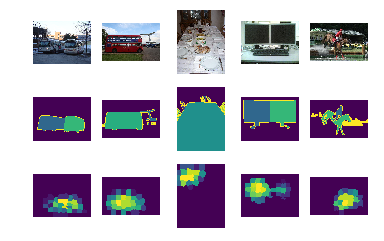

In [31]:
_, axs = plt.subplots(3, 5)
for col, bid in zip(axs.T, best):
    col[0].imshow(img_eval[bid])
    col[0].set_axis_off()
    col[1].matshow(ann_eval[bid])
    col[1].set_axis_off()
    col[2].matshow(seg_eval[bid])
    col[2].set_axis_off()
#plt.tight_layout()